In [215]:
import data as nfl
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# plt.style.use("seaborn-talk")
plt.style.use("ggplot")

pd.set_option("display.max_columns", 7)

In [216]:
data = pd.concat(
    [nfl.get_pbp_data(season).assign(season=season) for season in range(1999, 2025)]
)

/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/data.py:29: DtypeWarning: Columns (36,37,179,180,189,190,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'./data/play_by_play_{year}.csv')
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/data.py:29: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'./data/play_by_play_{year}.csv')
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/data.py:29: DtypeWarning: Columns (37,45,179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types

In [217]:
def dynamic_window_ewma(x):
    """
    Calculate rolling exponentially weighted EPA with a dynamic window size
    """
    values = np.zeros(len(x))
    for i, (_, row) in enumerate(x.iterrows()):
        epa = x.epa_shifted[: i + 1]
        if row.week > 10:
            values[i] = epa.ewm(min_periods=1, span=row.week).mean().values[-1]
        else:
            values[i] = epa.ewm(min_periods=1, span=10).mean().values[-1]

    return pd.Series(values, index=x.index)


# seperate EPA in to rushing offense, rushing defense, passing offense, passing defense for each team
rushing_offense_epa = (
    data.loc[data["rush_attempt"] == 1, :]
    .groupby(["posteam", "season", "week"], as_index=False)["epa"]
    .mean()
)

rushing_defense_epa = (
    data.loc[data["rush_attempt"] == 1, :]
    .groupby(["defteam", "season", "week"], as_index=False)["epa"]
    .mean()
)

passing_offense_epa = (
    data.loc[data["pass_attempt"] == 1, :]
    .groupby(["posteam", "season", "week"], as_index=False)["epa"]
    .mean()
)

passing_defense_epa = (
    data.loc[data["pass_attempt"] == 1, :]
    .groupby(["defteam", "season", "week"], as_index=False)["epa"]
    .mean()
)

# lag EPA one period back
rushing_offense_epa["epa_shifted"] = rushing_offense_epa.groupby("posteam")[
    "epa"
].shift()
rushing_defense_epa["epa_shifted"] = rushing_defense_epa.groupby("defteam")[
    "epa"
].shift()
passing_offense_epa["epa_shifted"] = passing_offense_epa.groupby("posteam")[
    "epa"
].shift()
passing_defense_epa["epa_shifted"] = passing_defense_epa.groupby("defteam")[
    "epa"
].shift()

# In each case, calculate EWMA with a static window and dynamic window and assign it as a column
rushing_offense_epa["ewma"] = rushing_offense_epa.groupby("posteam")[
    "epa_shifted"
].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_offense_epa["ewma_dynamic_window"] = (
    rushing_offense_epa.groupby("posteam").apply(dynamic_window_ewma).values
)

rushing_defense_epa["ewma"] = rushing_defense_epa.groupby("defteam")[
    "epa_shifted"
].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

rushing_defense_epa["ewma_dynamic_window"] = (
    rushing_defense_epa.groupby("defteam").apply(dynamic_window_ewma).values
)

passing_offense_epa["ewma"] = passing_offense_epa.groupby("posteam")[
    "epa_shifted"
].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_offense_epa["ewma_dynamic_window"] = (
    passing_offense_epa.groupby("posteam").apply(dynamic_window_ewma).values
)

passing_defense_epa["ewma"] = passing_defense_epa.groupby("defteam")[
    "epa_shifted"
].transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passing_defense_epa["ewma_dynamic_window"] = (
    passing_defense_epa.groupby("defteam").apply(dynamic_window_ewma).values
)

# Merge all the data together
offense_epa = rushing_offense_epa.merge(
    passing_offense_epa,
    on=["posteam", "season", "week"],
    suffixes=("_rushing", "_passing"),
).rename(columns={"posteam": "team"})
defense_epa = rushing_defense_epa.merge(
    passing_defense_epa,
    on=["defteam", "season", "week"],
    suffixes=("_rushing", "_passing"),
).rename(columns={"defteam": "team"})
epa = offense_epa.merge(
    defense_epa, on=["team", "season", "week"], suffixes=("_offense", "_defense")
)

# remove the first season of data
epa = epa.loc[epa["season"] != epa["season"].unique()[0], :]

epa = epa.reset_index(drop=True)

epa.head()

/var/folders/z0/jl3_m1r94gb2ypr7xq23dhkh0000gn/T/ipykernel_68515/1752190719.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rushing_offense_epa.groupby("posteam").apply(dynamic_window_ewma).values
/var/folders/z0/jl3_m1r94gb2ypr7xq23dhkh0000gn/T/ipykernel_68515/1752190719.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rushing_defense_epa.groupby("defteam").apply(dynamic_window_ewma).values
/var/f

,team,season,week,...,epa_shifted_passing_defense,ewma_passing_defense,ewma_dynamic_window_passing_defense
0,ARI,2000,1,...,0.269840,0.115978,0.115978
1,ARI,2000,2,...,-0.009200,0.092441,0.092441
2,ARI,2000,4,...,0.283460,0.128136,0.128136
3,ARI,2000,5,...,0.500345,0.197339,0.197339
4,ARI,2000,6,...,0.058499,0.171631,0.171631


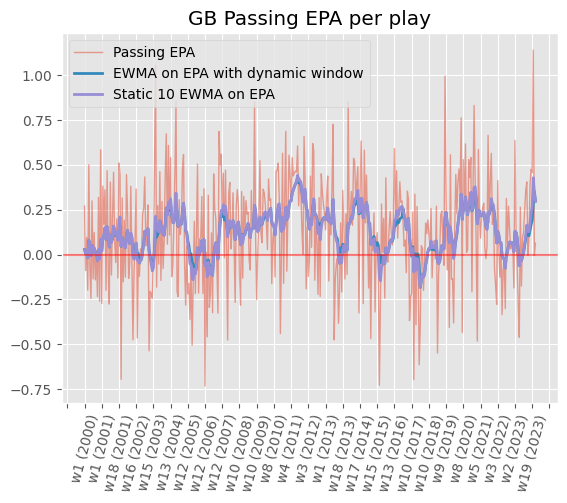

In [218]:
tm = (
    epa.loc[epa["team"] == "GB", :]
    .assign(
        season_week=lambda x: "w"
        + x.week.astype(str)
        + " ("
        + x.season.astype(str)
        + ")"
    )
    .set_index("season_week")
)

fig, ax = plt.subplots()

loc = plticker.MultipleLocator(base=16)  # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis="x", rotation=75)  # rotate the x-axis labels a bit

ax.plot(tm["epa_shifted_passing_offense"], lw=1, alpha=0.5)
ax.plot(tm["ewma_dynamic_window_passing_offense"], lw=2)
ax.plot(tm["ewma_passing_offense"], lw=2)
plt.axhline(y=0, color="red", lw=1.5, alpha=0.5)

ax.legend(["Passing EPA", "EWMA on EPA with dynamic window", "Static 10 EWMA on EPA"])
ax.set_title("GB Passing EPA per play")
plt.show()

In [219]:
schedule = (
    data[["season", "week", "home_team", "away_team", "home_score", "away_score"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .assign(home_team_win=lambda x: (x.home_score > x.away_score).astype(int))
)

df = schedule.merge(
    epa.rename(columns={"team": "home_team"}), on=["home_team", "season", "week"]
).merge(
    epa.rename(columns={"team": "away_team"}),
    on=["away_team", "season", "week"],
    suffixes=("_home", "_away"),
)

df.head()

,season,week,home_team,...,epa_shifted_passing_defense_away,ewma_passing_defense_away,ewma_dynamic_window_passing_defense_away
0,2000,1,NYG,...,0.269840,0.115978,0.115978
1,2000,1,PIT,...,-0.314740,-0.201766,-0.201766
2,2000,1,WAS,...,-0.368611,0.001226,0.001226
3,2000,1,MIN,...,0.365886,0.106318,0.106318
4,2000,1,LA,...,-0.078273,-0.086481,-0.086481


In [220]:
target = "home_team_win"
features = [column for column in df.columns if "ewma" in column and "dynamic" in column]
for feature in features:
    print(feature)

ewma_dynamic_window_rushing_offense_home
ewma_dynamic_window_passing_offense_home
ewma_dynamic_window_rushing_defense_home
ewma_dynamic_window_passing_defense_home
ewma_dynamic_window_rushing_offense_away
ewma_dynamic_window_passing_offense_away
ewma_dynamic_window_rushing_defense_away
ewma_dynamic_window_passing_defense_away


In [221]:
df = df.dropna()

X = df.loc[df["season"] != 2024, features].values
y = df.loc[df["season"] != 2024, target].values

clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression()

In [222]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier()

# Fit the model
rf_model.fit(X, y)

# Perform cross-validation
accuracy_scores = cross_val_score(rf_model, X, y, cv=10, scoring="accuracy")
print(
    f"Random Forest Model Accuracy: {np.mean(accuracy_scores)} (+/- {np.std(accuracy_scores) * 2})"
)

Random Forest Model Accuracy: 0.6167008522316915 (+/- 0.030078117540430868)


In [223]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [100],
    "max_depth": [5],
    "min_samples_split": [5],
    "min_samples_leaf": [1],
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring="accuracy"
)

grid_search_rf.fit(X, y)
print(f"Best Params for Random Forest: {grid_search_rf.best_params_}")
print(f"Best Score for Random Forest: {grid_search_rf.best_score_}")

Best Params for Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score for Random Forest: 0.6270948879433718


In [225]:
# Use nerual network
from sklearn.neural_network import MLPClassifier

# Initialize the model
nn_model = MLPClassifier()

# Fit the model
nn_model.fit(X, y)

# Perform cross-validation
accuracy_scores = cross_val_score(nn_model, X, y, cv=10, scoring="accuracy")
print(
    f"Neural Network Model Accuracy: {np.mean(accuracy_scores)} (+/- {np.std(accuracy_scores) * 2})"
)

/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network Model Accuracy: 0.6284967981125715 (+/- 0.030939160572146095)


In [226]:
from sklearn.ensemble import VotingClassifier

# Define your models
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = MLPClassifier()

# Create an ensemble model with hard voting
ensemble = VotingClassifier(
    estimators=[("lr", clf1), ("rf", clf2), ("mlp", clf3)], voting="hard"
)

# Fit and evaluate the ensemble
ensemble.fit(X, y)
accuracy_scores = cross_val_score(ensemble, X, y, cv=10, scoring="accuracy")
print(
    f"Ensemble Accuracy: {np.mean(accuracy_scores)} (+/- {np.std(accuracy_scores) * 2})"
)

/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packag

Ensemble Accuracy: 0.6328402908180462 (+/- 0.03157177632570447)


In [227]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Create the base models
base_learners = [("rf", RandomForestClassifier()), ("nn", MLPClassifier())]

# Meta-model (you can experiment with different meta-models like Logistic Regression, SVM, etc.)
stacking_model = StackingClassifier(
    estimators=base_learners, final_estimator=LogisticRegression(), cv=5
)

# Fit and evaluate
stacking_model.fit(X, y)
accuracy_scores = cross_val_score(stacking_model, X, y, cv=5, scoring="accuracy")
print(
    f"Stacking Model Accuracy: {np.mean(accuracy_scores)} (+/- {np.std(accuracy_scores) * 2})"
)

/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packag

Stacking Model Accuracy: 0.6298870278370734 (+/- 0.018406812763390033)


/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [228]:
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring="neg_log_loss")

print(f"Model Accuracy: {np.mean(accuracy_scores)} (+/- {np.std(accuracy_scores) * 2})")

Model Accuracy: 0.6333066108141943 (+/- 0.035221307269052954)


In [229]:
print("Neg log loss:", np.mean(log_losses))

Neg log loss: -0.6394521997547723


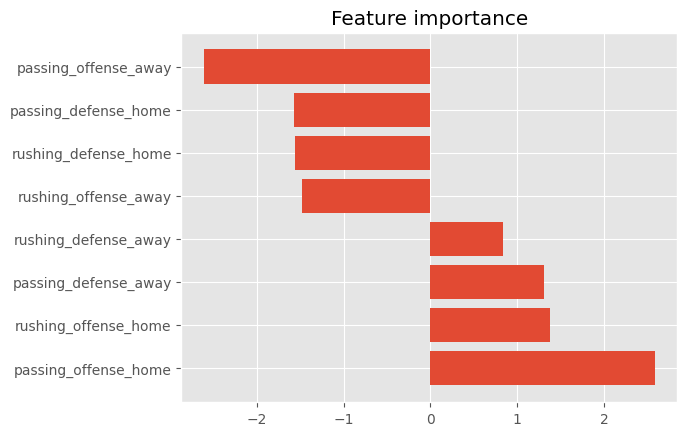

In [230]:
fig, ax = plt.subplots()

feature_names = ["_".join(feature_name.split("_")[3:]) for feature_name in features]

coef_ = clf.coef_[0]

features_coef_sorted = sorted(
    zip(feature_names, coef_), key=lambda x: x[-1], reverse=True
)

features_sorted = [feature for feature, _ in features_coef_sorted]
coef_sorted = [coef for _, coef in features_coef_sorted]

ax.set_title("Feature importance")

ax.barh(features_sorted, coef_sorted)
plt.show()

In [231]:
df_target = df.loc[(df["season"] == 2024)].assign(
    predicted_winner=lambda x: clf.predict(x[features]),
    home_team_win_probability=lambda x: clf.predict_proba(x[features])[:, 1],
)[
    [
        "home_team",
        "away_team",
        "week",
        "predicted_winner",
        "home_team_win_probability",
        "home_team_win",
    ]
]

df_target["actual_winner"] = df_target.apply(
    lambda x: x.home_team if x.home_team_win else x.away_team, axis=1
)
df_target["predicted_winner"] = df_target.apply(
    lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1
)
df_target["win_probability"] = df_target.apply(
    lambda x: (
        x.home_team_win_probability
        if x.predicted_winner == x.home_team
        else 1 - x.home_team_win_probability
    ),
    axis=1,
)
df_target["correct_prediction"] = (
    df_target["predicted_winner"] == df_target["actual_winner"]
).astype(int)

df_target = df_target.drop(columns=["home_team_win_probability", "home_team_win"])

df_target.sort_values(by="win_probability", ascending=False).reset_index(
    drop=True
).head(10)

/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/joshcaponigro/Documents/Coding/Fantasy-Football-Tools/NFLPredictor/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,NO,CAR,1,NO,NO,0.861925,1
1,SF,NYJ,1,SF,SF,0.839264,1
2,TB,WAS,1,TB,TB,0.824144,1
3,GB,IND,2,GB,GB,0.742913,1
4,BAL,LV,2,BAL,LV,0.736779,0
5,PHI,GB,1,GB,PHI,0.713396,0
6,BUF,ARI,1,BUF,BUF,0.711426,1
7,CIN,NE,1,CIN,NE,0.703848,0
8,JAX,CLE,2,JAX,CLE,0.656970,0
9,TEN,NYJ,2,TEN,NYJ,0.652983,0


In [232]:
correct = (
    df_target.loc[df_target["correct_prediction"] == 1]
    .groupby("week")["correct_prediction"]
    .sum()
)

num_games = df_target.groupby("week")["correct_prediction"].size()

results = correct / num_games

results

week
1    0.625000
2    0.454545
Name: correct_prediction, dtype: float64

In [233]:
# Total correctness and avg correctness by week
correct.sum() / num_games.sum(), results.mean()

(np.float64(0.5555555555555556), np.float64(0.5397727272727273))

In [234]:
display(
    df_target.loc[df_target["week"] == results.idxmax()].sort_values(
        by="win_probability", ascending=False
    )
)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
6447,NO,CAR,1,NO,NO,0.861925,1
6457,SF,NYJ,1,SF,SF,0.839264,1
6460,TB,WAS,1,TB,TB,0.824144,1
6450,PHI,GB,1,GB,PHI,0.713396,0
6445,BUF,ARI,1,BUF,BUF,0.711426,1
6456,CIN,NE,1,CIN,NE,0.703848,0
6448,CLE,DAL,1,DAL,DAL,0.645597,1
6459,CHI,TEN,1,CHI,CHI,0.628046,1
6455,NYG,MIN,1,NYG,MIN,0.572401,0
6452,MIA,JAX,1,MIA,MIA,0.570953,1


In [235]:
df_target.loc[df_target["week"] == 1]

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
6445,BUF,ARI,1,BUF,BUF,0.711426,1
6446,KC,BAL,1,BAL,KC,0.522349,0
6447,NO,CAR,1,NO,NO,0.861925,1
6448,CLE,DAL,1,DAL,DAL,0.645597,1
6449,SEA,DEN,1,SEA,SEA,0.558496,1
6450,PHI,GB,1,GB,PHI,0.713396,0
6451,IND,HOU,1,IND,HOU,0.509979,0
6452,MIA,JAX,1,MIA,MIA,0.570953,1
6453,DET,LA,1,DET,DET,0.563367,1
6454,LAC,LV,1,LV,LAC,0.564620,0


In [236]:
# How many predictions with win probability above 60% are correct?
df_target.loc[df_target["win_probability"] > 0.6, "correct_prediction"].mean()

np.float64(0.5714285714285714)

In [237]:
# How many predictions with win probability above 70% are correct?
df_target.loc[df_target["win_probability"] > 0.7, "correct_prediction"].mean()

np.float64(0.625)

In [238]:
# How many predictions with win probability above 75% are correct?
df_target.loc[df_target["win_probability"] > 0.75, "correct_prediction"].mean()

np.float64(1.0)

In [239]:
# How many predictions with win probability above 80% are correct?
df_target.loc[df_target["win_probability"] > 0.8, "correct_prediction"].mean()

np.float64(1.0)

In [240]:
# How many predictions with win probability above 85% are correct?
df_target.loc[df_target["win_probability"] > 0.8, "correct_prediction"].mean()

np.float64(1.0)

In [241]:
import joblib

# Save the model to a file
joblib.dump(clf, "./models/clf.pkl")

['./models/clf.pkl']

In [242]:
import itertools

HOME_TEAM = "NYJ"
AWAY_TEAM = "NE"


def ewma(data, window):
    """
    Calculate the most recent value for EWMA given an array of data and a window size
    """
    alpha = 2 / (window + 1.0)
    alpha_rev = 1 - alpha
    scale = 1 / alpha_rev
    n = data.shape[0]
    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0] * alpha_rev ** (r + 1)
    pw0 = alpha * alpha_rev ** (n - 1)
    mult = data * pw0 * scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums * scale_arr[::-1]
    return out[-1]


data_2024 = data.loc[(data["season"] == 2024)]
offense = data_2024.loc[
    (data_2024["posteam"] == HOME_TEAM) | (data_2024["posteam"] == AWAY_TEAM)
]
defense = data_2024.loc[
    (data_2024["defteam"] == HOME_TEAM) | (data_2024["defteam"] == AWAY_TEAM)
]

rushing_offense = (
    offense.loc[offense["rush_attempt"] == 1]
    .groupby(["posteam", "week"], as_index=False)["epa"]
    .mean()
    .rename(columns={"posteam": "team"})
)
passing_offense = (
    offense.loc[offense["pass_attempt"] == 1]
    .groupby(["posteam", "week"], as_index=False)["epa"]
    .mean()
    .rename(columns={"posteam": "team"})
)
rushing_defense = (
    defense.loc[defense["rush_attempt"] == 1]
    .groupby(["defteam", "week"], as_index=False)["epa"]
    .mean()
    .rename(columns={"defteam": "team"})
)
passing_defense = (
    defense.loc[defense["pass_attempt"] == 1]
    .groupby(["defteam", "week"], as_index=False)["epa"]
    .mean()
    .rename(columns={"defteam": "team"})
)

super_bowl_X = np.zeros(8)

for i, (tm, stat_df) in enumerate(
    itertools.product(
        [HOME_TEAM, AWAY_TEAM],
        [rushing_offense, passing_offense, rushing_defense, passing_defense],
    )
):
    ewma_value = ewma(stat_df.loc[stat_df["team"] == tm]["epa"].values, 20)
    super_bowl_X[i] = ewma_value

predicted_winner = clf.predict(super_bowl_X.reshape(1, 8))[0]
predicted_proba = clf.predict_proba(super_bowl_X.reshape(1, 8))[0]

winner = HOME_TEAM if predicted_winner else AWAY_TEAM
win_prob = predicted_proba[-1] if predicted_winner else predicted_proba[0]

In [243]:
winner, win_prob

('NE', np.float64(0.58146293700059))